#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, GridSearchCV, HalvingGridSearchCV, cross_val_score)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

In [ ]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
#явные дубликаты
data.duplicated().sum()

0

In [ ]:
#устанавливаю индекс таблицы равным столбцу datetime
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
#хронология
data.sort_index(inplace=True)
data.index.is_monotonic

True

### Выводы

Датафрейм состоит из двух столбцов, дата и количество заказов. Пропусков и дубликатов не обнаружено. Данные находятся в хронологическом порядке. Был установлен индекс таблицы равным столбцу datetime

## Анализ

In [ ]:
#ресемплирование по часу
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='datetime'>

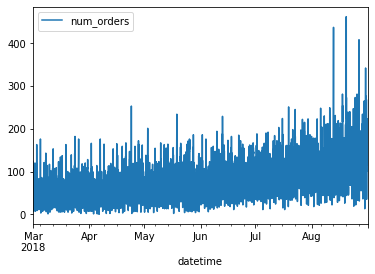

In [ ]:
data.plot()

<AxesSubplot:xlabel='datetime'>

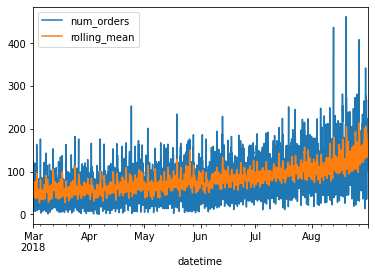

In [ ]:
#скользящее среднее
data_rollin = data.copy()
data_rollin['rolling_mean'] =data_rollin.rolling(10).mean()
data_rollin.plot()

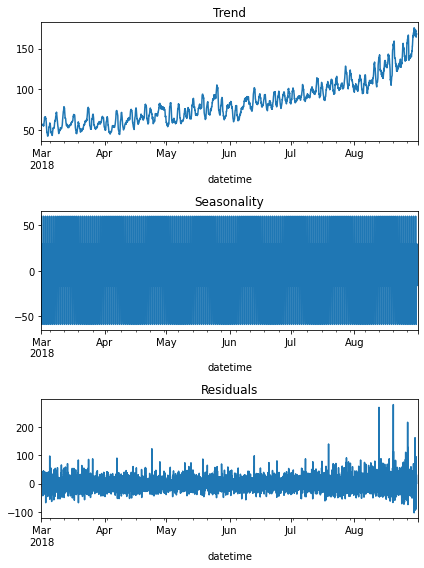

In [ ]:
#тренды и сезонность
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

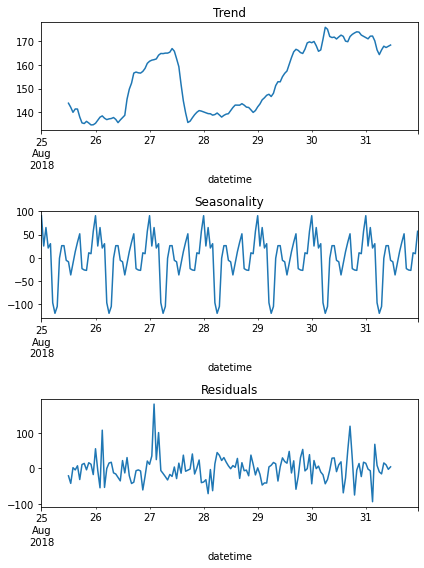

In [ ]:
#тренды и сезонность за неделю
data_week = data['2018-08-25':]
decomposed = seasonal_decompose(data_week)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

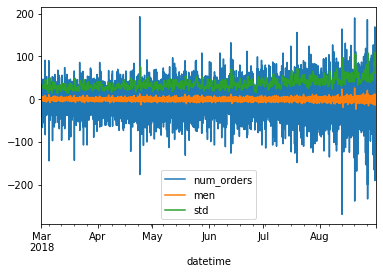

In [ ]:
# разность временного ряда
data = data - data.shift()
data['men'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

<AxesSubplot:xlabel='datetime'>

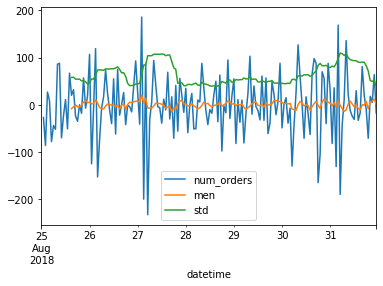

In [ ]:
# разность временного ряда за неделю
data_week = data_week - data_week.shift()
data_week['men'] = data_week['num_orders'].rolling(15).mean()
data_week['std'] = data_week['num_orders'].rolling(15).std()
data_week.plot()

### Выводы

- Количество заказов со временем увеличивается
- Временной ряд не стационарный, так как идет тенд на возрастание, среднее значение и стандартное отклонение со временем увеличиваются
- Так же по графикам хорошо видна сезонность


## Обучение

In [ ]:
#создаю новые признаки
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data

make_features(data, 10, 10)

,num_orders,men,std,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,NaN,NaN,NaN,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,-39.0,NaN,NaN,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,-14.0,NaN,NaN,1,3,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,-5.0,NaN,NaN,1,3,-14.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,-23.0,NaN,NaN,1,3,-5.0,-14.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,-8.800000,71.667087,31,4,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-12.0,21.0,2.5
2018-08-31 20:00:00,18.0,5.066667,51.344031,31,4,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-12.0,-6.7
2018-08-31 21:00:00,5.0,8.266667,49.600499,31,4,18.0,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,-24.0,-3.7


In [ ]:
#разделю на выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3959, 15)
(442, 15)
(3959, 1)
(442, 1)


In [ ]:
tscv = TimeSeriesSplit(n_splits=8)

In [ ]:
def metrics(model):

    RMSE = abs(model.best_score_) ** .5

    print(f"Best RMSE: {RMSE:.5f}")

In [ ]:
#Решающее дерево - подбор лучших параметров
model_tree = DecisionTreeRegressor(random_state=42)
parameters = {'max_depth':range(12, 20),
              'min_samples_split': range(2, 4),
              'min_samples_leaf': range(1, 3)}

gs_tree = GridSearchCV(model_tree, parameters, cv=tscv, scoring='neg_mean_squared_error', n_jobs = -1)
gs_tree.fit(features_train, target_train)

best_tree_params = gs_tree.best_params_

print('Лучшие параметры:',best_tree_params)
metrics(gs_tree)

Лучшие параметры: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best RMSE: 33.60097


In [ ]:
#Случайный лес - подбор лучших параметров
model_forest = RandomForestRegressor(random_state=42)
parameter = {'max_depth':range(10, 100, 30),
              'n_estimators': range(2,10,2)}

gs_forest = GridSearchCV(model_forest, parameter, cv=tscv, scoring='neg_mean_squared_error', n_jobs = -1)
gs_forest.fit(features_train, target_train)

best_forest_params = gs_forest.best_params_

print('Лучшие параметры:',best_forest_params)
metrics(gs_forest)

Лучшие параметры: {'max_depth': 10, 'n_estimators': 8}
Best RMSE: 26.06706


In [ ]:
model_l = LinearRegression()

cros_val = (cross_val_score(model_l,
                             features_train,
                             target_train,
                             cv=tscv,
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Best RMSE: ', cros_val)

Best RMSE:  25.02073641381025


In [ ]:
#LGBMRegressor - подбор лучших параметров
model_lgbm = LGBMRegressor(random_state=42)
param = {'num_leaves':[30, 50, 100, 1000], 'learning_rate':[.1, .3, .5]}

gs = GridSearchCV(model_lgbm, param, cv=tscv, scoring='neg_mean_squared_error', n_jobs = -1)
gs.fit(features_train, target_train)

best_lgbm_params = gs.best_params_

print('Лучшие параметры:',best_lgbm_params)
metrics(gs)

Лучшие параметры: {'learning_rate': 0.1, 'num_leaves': 30}
Best RMSE: 23.36726


### Выводы

- в таблицу были добавлены новые признаки
- признаки были разделены на тренировочную и тестовую выборки
- размер n_splits  должен быть указан такой, что бы при проведении кросс-валидации размер валидационной выборки примерно совпадал с размером тестовой. Размер тестовой - 10%, а валидационной - 1/(n_splits+1) части от обучающей
- для тестирования были выбраны модели : DecisionTreeRegressor, RandomForestRegressor, LinearRegression, LGBMRegressor. Лучшее значение на тренировочной выборке показала модель LGBMRegressor (Best RMSE: 23.36726)

## Тестирование

In [ ]:
#LGBMRegressor на тесте
model_h = LGBMRegressor(random_state=42, learning_rate= .1, num_leaves=30)

model_h.fit(features_train, target_train)

model_pr = model_h.predict(features_test)

rsme_f = mean_squared_error(target_test, model_pr) ** .5

print(f"RMSE LGBMRegressor:{rsme_f:.5f}")

RMSE LGBMRegressor:39.77748


## Выводы

- Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Для этого были изучены и проанализированы данные.
- Было выяснено что количество заказов со временем увеличивается, временной ряд не стационарный, так как идет тенд на возрастание, среднее значение и стандартное отклонение со временем увеличиваются.Так же по графикам хорошо видна сезонность
- для тестирования были выбраны модели : DecisionTreeRegressor, RandomForestRegressor, LinearRegression, LGBMRegressor. Лучшее значение на тренировочной выборке показала модель LGBMRegressor (Best RMSE: 24.13679)
- На тестовой выборке модель LGBMRegressor показала тоже неплохой результат 40.66068